# Mineral Prospectivity Mapping

### Ehsan Farahbakhsh

*EarthByte Group, School of Geosciences, University of Sydney, NSW 2006, Australia*

This notebook enables the user to create the prospectivity map of target mineralization. It comprises two main sections; in the first section, the available datasets are visualized, and in the second section, a variety of machine learning methods are applied to create a prospectivity map.

### Libraries

In [4]:
# !conda install -c conda-forge contextily --verbose
# !conda install contextily
# !conda install -c conda-forge ipywidgets -v
# !pip install pulearn -v
# !conda install -c conda-forge rioxarray -v
# !conda install -c conda-forge skimage -v
# !conda install -c conda-forge scikit-image -v
# !conda install -c conda-forge scikit-learn -v
# !conda install -c conda-forge tqdm -v
# !conda install -c conda-forge seaborn -v

^C


In [4]:
# !conda list scikit-image
# !conda list numpy
# !conda list scipy
# !conda list
!pip list

Package                       Version
----------------------------- --------------------
affine                        2.4.0
aiohttp                       3.8.1
aiosignal                     1.2.0
alabaster                     0.7.12
anaconda-client               1.9.0
anaconda-navigator            2.1.4
anaconda-project              0.10.2
anyio                         3.5.0
appdirs                       1.4.4
argon2-cffi                   21.3.0
argon2-cffi-bindings          21.2.0
arrow                         1.2.2
astroid                       2.6.6
astropy                       5.0.4
asttokens                     2.0.5
async-timeout                 4.0.1
atomicwrites                  1.4.0
attrs                         21.4.0
Automat                       20.2.0
autopep8                      1.6.0
Babel                         2.9.1
backcall                      0.2.0
backports.functools-lru-cache 1.6.4
backports.tempfile            1.0
backports.weakref             1.0.post1
bcr

In [1]:
# import sklearn
# print(sklearn.__version__)

1.2.2


In [1]:
import warnings
warnings.filterwarnings('ignore')

from collections import namedtuple
import contextily as cx
import csv
import functools
import geopandas as gpd
import glob
from ipywidgets import interact
from matplotlib.patches import Patch
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import math
from mpl_toolkits.axes_grid1 import make_axes_locatable

import numpy as np
from numpy import genfromtxt

from osgeo import gdal
from osgeo import osr
import os
import pandas as pd
from pprint import pprint
from pulearn import BaggingPuClassifier
import rioxarray as rxr
from scipy import interp
import scipy.spatial
from scipy.spatial import distance_matrix
import seaborn as sns
from shapely.geometry import Point
from shapely.geometry import mapping
import shapely.strtree
from skimage import exposure, util
from skimage.feature import graycomatrix, graycoprops
from tqdm.notebook import tqdm

import sklearn
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import auc, roc_curve
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder

In [4]:
# nsw_boundary = gpd.read_file('./Datasets/Frames/NSW_STATE_POLYGON_shp_GDA94_NoIsland.shp')
# lachlan_boundary = gpd.read_file('./Datasets/Frames/Lachlan_Boundary.shp')

# # comment one of the lines below to map cobalt or nickel occurrences
# #commodity = gpd.read_file('./Datasets/Mineral Occurrences/cobalt.shp')
# # commodity = gpd.read_file('./Datasets/Mineral Occurrences/nickel.shp')
# # commodity = gpd.read_file('./Datasets/Mineral_Occurrences_2/MinOcc.shp')
# commodity = gpd.read_file('./Datasets/Mineral_Occurrences_3/NiCo_lat.shp')

# mineralization_types = commodity.NSW_CLASS.unique()
# mineralization_types = np.array(mineralization_types.astype(str))
# mineralization_types.sort()

# print(commodity.NSW_CLASS.value_counts())

# @interact(mineralization_type=mineralization_types)
# def show_map(mineralization_type):
#     fig, ax = plt.subplots(figsize=(15, 15))
#     data = commodity[commodity.NSW_CLASS==mineralization_type]
#     data.plot(ax=ax, edgecolor='black', color='yellow')
#     nsw_boundary.plot(ax=ax, edgecolor='white', color='none', linewidth=2)
#     lachlan_boundary.plot(ax=ax, edgecolor='black', color='none', linewidth=2)
#     cx.add_basemap(ax, crs='EPSG:4283', source=cx.providers.Esri.WorldGrayCanvas)
#     ax.set_title(mineralization_type)
#     plt.show()

Ni-Co laterites    59
Name: NSW_CLASS, dtype: int64


interactive(children=(Dropdown(description='mineralization_type', options=('Ni-Co laterites',), value='Ni-Co l…

### Target Commodity and Mineralisation Type

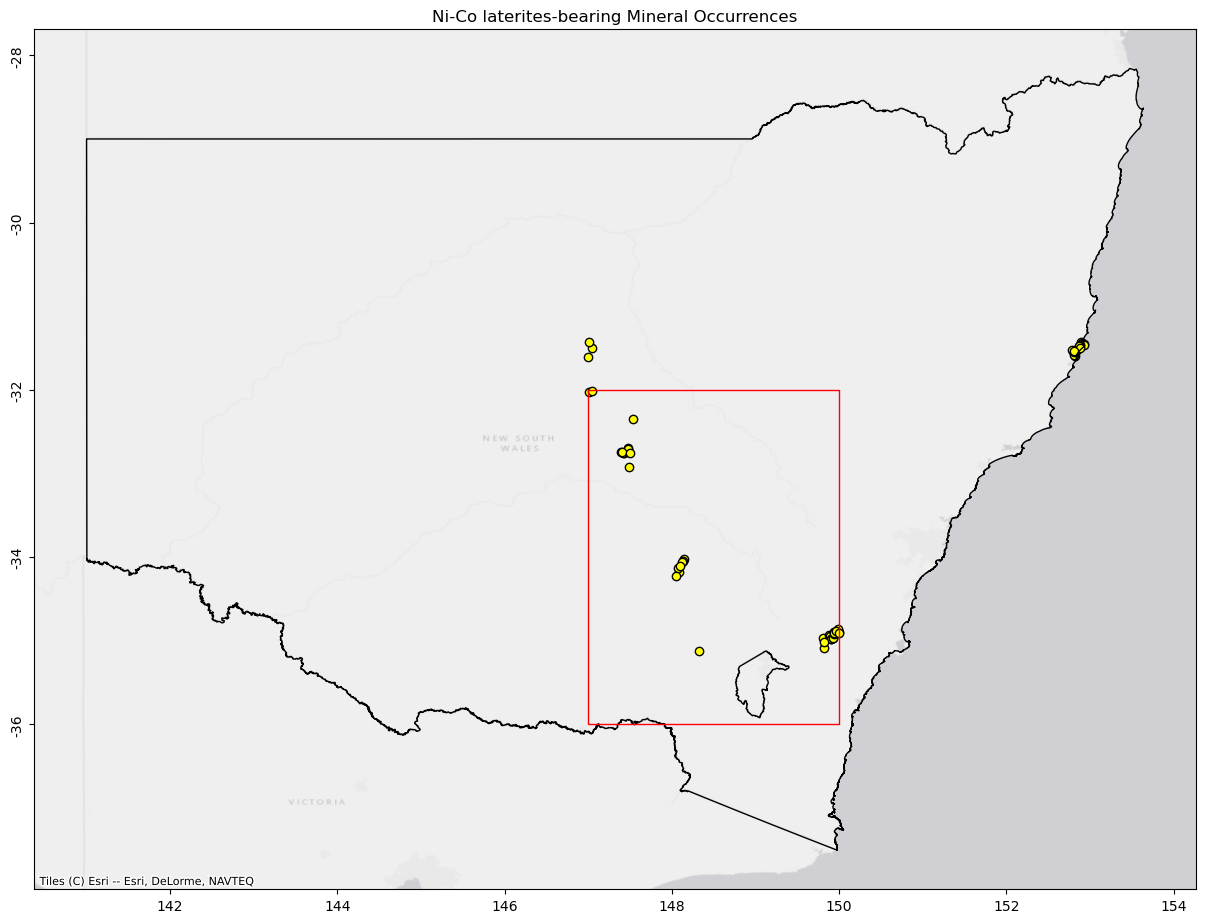

In [2]:
# uncomment the target commodity
commodity = 'Ni-Co laterites'

# uncomment the relevant shapefile
# mines = gpd.read_file('./Datasets/Mineral_Occurrences_2/MinOcc.shp')
mines = gpd.read_file('./Datasets/Mineral_Occurrences_3/NiCo_lat.shp')

# read boundaries
# sa_boundary_gda94 = gpd.read_file('./Datasets/Frames/SA_Frame_GDA94.shp')
# sa_boundary = sa_boundary_gda94.to_crs('epsg:7853')
# gc_boundary_gda94 = gpd.read_file('./Datasets/Frames/GC_Frame_GDA94.shp')
# gc_boundary = gc_boundary_gda94.to_crs('epsg:7853')
nsw_boundary = gpd.read_file('./Datasets/Frames/NSW_STATE_POLYGON_shp_GDA94_NoIsland.shp')
lachlan_boundary = gpd.read_file('./Datasets/Frames/Lachlan_Boundary.shp')

# target mineralisation types
nsw_class = ['Ni-Co laterites']

# plot the mineral occurrences
fig, ax = plt.subplots(figsize=(15, 15))
mines.plot(ax=ax, edgecolor='black', color='yellow')
nsw_boundary.plot(ax=ax, edgecolor='black', color='none', linewidth=1)
lachlan_boundary.plot(ax=ax, edgecolor='red', color='none', linewidth=1)
# Esri: WorldStreetMap, DeLorme, WorldTopoMap, WorldImagery, WorldTerrain, WorldShadedRelief, WorldPhysical, OceanBasemap,
# NatGeoWorldMap, WorldGrayCanvas
cx.add_basemap(ax, crs='EPSG:4283', source=cx.providers.Esri.WorldGrayCanvas)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.f'))
plt.yticks(rotation=90, va='center')
ax.xaxis.set_major_formatter(FormatStrFormatter('%.f'))
ax.set_title(f'{commodity}-bearing Mineral Occurrences')
plt.show()

In [3]:
# comment one of the lines below to map cobalt or nickel occurrences
#commodity = gpd.read_file('./Datasets/Mineral Occurrences/cobalt.shp')
# commodity = gpd.read_file('./Datasets/Mineral Occurrences/nickel.shp')
commod = gpd.read_file('./Datasets/Mineral_Occurrences_2/MinOcc.shp')
# commodity = gpd.read_file('./Datasets/Mineral_Occurrences_3/NiCo_lat.shp')

mineralization_types = commod.NSW_CLASS.unique()
mineralization_types = np.array(mineralization_types.astype(str))
mineralization_types.sort()

print(commod.NSW_CLASS.value_counts())

@interact(mineralization_type=mineralization_types)
def show_map(mineralization_type):
    fig, ax = plt.subplots(figsize=(15, 15))
    data = commod[commod.NSW_CLASS==mineralization_type]
    data.plot(ax=ax, edgecolor='black', color='yellow')
    nsw_boundary.plot(ax=ax, edgecolor='white', color='none', linewidth=2)
    lachlan_boundary.plot(ax=ax, edgecolor='black', color='none', linewidth=2)
    cx.add_basemap(ax, crs='EPSG:4283', source=cx.providers.Esri.WorldGrayCanvas)
    ax.set_title(mineralization_type)
    plt.show()

NSW_CLASS
Construction materials                                       9883
Structurally controlled low sulfide Au                       3962
Unclassified                                                 3425
Structurally controlled high sulfide base metal (+/- Au)     1796
Au-Ag eluvial/alluvial/deep lead                             1473
                                                             ... 
Mafic setting-hosted Cu-Zn-(Au-Ag)                              1
Nb-Y-F pegmatite                                                1
Ultramafic-related deposits - Picrite-related Ni-Cu-(PGE)       1
Au-(Bi) skarn                                                   1
Sandstone-hosted U                                              1
Name: count, Length: 74, dtype: int64


interactive(children=(Dropdown(description='mineralization_type', options=('Amagmatic banded iron formation', …

### Raster datasets
#### Magnetic field intensity

In [4]:
magnetic_filenames = [
    f'./Datasets/Magnetics/Magmap2019_tmr_rtp_enh_Bzz_PGravTHD.tif',
    f'./Datasets/Magnetics/Magmap2019_tmi_rtp_upcon_UC42km50kmRes.tif',
    f'./Datasets/Magnetics/Magmap2019_tmi_rtp_upcon_UC36km42kmRes.tif',
    f'./Datasets/Magnetics/Magmap2019_tmi_rtp_upcon_UC24km30kmRes.tif',
    f'./Datasets/Magnetics/Magmap2019_tmi_rtp_upcon_UC16km20kmRes.tif',
    f'./Datasets/Magnetics/Magmap2019_tmi_rtp_upcon_UC12km16kmRes.tif',
    f'./Datasets/Magnetics/Magmap2019_tmi_rtp_upcon_UC8km12kmRes.tif',
    f'./Datasets/Magnetics/Magmap2019_tmi_rtp_upcon_UC4km8kmRes.tif',
    f'./Datasets/Magnetics/Magmap2019_tmi_rtp_upcon_UC2km4kmRes.tif',
    f'./Datasets/Magnetics/Magmap2019_tmi_rtp_upcon_UC1km2kmRes.tif',
    f'./Datasets/Magnetics/Magmap2019_tmi_rtp_upcon_UC0m500mRes.tif',
    f'./Datasets/Magnetics/Magmap2019_tmi_rtp_enh_PGrav.tif',
    f'./Datasets/Magnetics/Magmap2019_tmi_rtp_enh_Bzz_PSusp.tif',
    f'./Datasets/Magnetics/Magmap2019_tmi_rtp_enh_Bzz_Phase.tif',
    f'./Datasets/Magnetics/Magmap2019_tmi_rtp_enh_Bzz.tif',
    f'./Datasets/Magnetics/Magmap2019_tmi_rtp_as_.tif',
    f'./Datasets/Magnetics/Magmap2019_tmi_rtp_05vd.tif',
    f'./Datasets/Magnetics/Magmap2019_tmi_rtp_1vd.tif',
    f'./Datasets/Magnetics/Magmap2019_tmi_rtp.tif',
    f'./Datasets/Magnetics/Magmap2019_tmi_cellsize40m.tif',
    f'./Datasets/Magnetics/Magmap2019_tmi_1vd.tif',
    f'./Datasets/Magnetics/Magmap2019_tmi.tif'
    ]

@interact(dataset=magnetic_filenames)
def show_dist(dataset):
    raster = rxr.open_rasterio(dataset, masked=True).squeeze()
    raster = raster.rio.reproject(nsw_boundary.crs)
    raster_clipped = raster.rio.clip(lachlan_boundary.geometry.apply(mapping))
    raster_clippd = np.array(raster_clipped)

    bounds = lachlan_boundary.bounds
    extent = [bounds.loc[0]['minx'], bounds.loc[0]['maxx'], bounds.loc[0]['miny'], bounds.loc[0]['maxy']]

    v_mean = np.array(np.nanmean(raster_clipped))
    v_std = np.array(np.nanstd(raster_clipped))

    fig, ax = plt.subplots(figsize=(15, 15))
    lachlan_boundary.plot(ax=ax, edgecolor='black', color='none', linewidth=2)
    cx.add_basemap(ax, crs='EPSG:4283', source=cx.providers.Esri.WorldGrayCanvas)
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.f'))
    plt.yticks(rotation=90, va='center')
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.f'))
    cb = ax.imshow(raster_clipped, cmap='Spectral_r', extent=extent, vmin=v_mean-v_std, vmax=v_mean+v_std)
    divider = make_axes_locatable(ax)
    cax = divider.new_vertical(size='5%', pad=0.5, pack_start=True)
    fig.add_axes(cax)
    plt.colorbar(cb, orientation='horizontal', label='Total magnetic intensity (nT)', cax=cax)
    plt.show()

interactive(children=(Dropdown(description='dataset', options=('./Datasets/Magnetics/Magmap2019_tmr_rtp_enh_Bz…

#### Gravity

In [5]:
gravity_filenames = [
    f'./Datasets/Gravity/Gravmap2019_freeair_IA.tif',
    f'./Datasets/Gravity/Gravmap2019_freeair.tif',
    f'./Datasets/Gravity/Gravmap2019_dtgir_tilt_IA.tif',
    f'./Datasets/Gravity/Gravmap2019_dtgir_tilt.tif',
    f'./Datasets/Gravity/Gravmap2019_dtgir_IA.tif',
    f'./Datasets/Gravity/Gravmap2019_dtgir_05vd_IA.tif',
    f'./Datasets/Gravity/Gravmap2019_dtgir_05vd.tif',
    f'./Datasets/Gravity/Gravmap2019_dtgir_1vd_IA.tif',
    f'./Datasets/Gravity/Gravmap2019_dtgir_1vd.tif',
    f'./Datasets/Gravity/Gravmap2019_dtgir.tif',
    f'./Datasets/Gravity/Gravmap2019_cscba_tilt_IA.tif',
    f'./Datasets/Gravity/Gravmap2019_cscba_tilt.tif',
    f'./Datasets/Gravity/Gravmap2019_cscba_IA.tif',
    f'./Datasets/Gravity/Gravmap2019_cscba_05vd_IA.tif',
    f'./Datasets/Gravity/Gravmap2019_cscba_05vd.tif',
    f'./Datasets/Gravity/Gravmap2019_cscba_1vd_IA.tif',
    f'./Datasets/Gravity/Gravmap2019_cscba_1vd.tif',
    f'./Datasets/Gravity/Gravmap2019_cscba.tif',
    f'./Datasets/Gravity/Gravmap2016_scba.tif',
    f'./Datasets/Gravity/Gravmap2016_iso_resid_anom.tif',
    f'./Datasets/Gravity/Gravmap2016_cscba.tif'
    ]

@interact(dataset=gravity_filenames)
def show_dist(dataset):
    raster = rxr.open_rasterio(dataset, masked=True).squeeze()
    raster = raster.rio.reproject(nsw_boundary.crs)
    raster_clipped = raster.rio.clip(lachlan_boundary.geometry.apply(mapping))
    raster_clippd = np.array(raster_clipped)

    bounds = lachlan_boundary.bounds
    extent = [bounds.loc[0]['minx'], bounds.loc[0]['maxx'], bounds.loc[0]['miny'], bounds.loc[0]['maxy']]

    v_mean = np.array(np.nanmean(raster_clipped))
    v_std = np.array(np.nanstd(raster_clipped))
    fig, ax = plt.subplots(figsize=(15, 15))
    lachlan_boundary.plot(ax=ax, edgecolor='black', color='none', linewidth=2)
    cx.add_basemap(ax, crs='EPSG:4283', source=cx.providers.Esri.WorldGrayCanvas)
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.f'))
    plt.yticks(rotation=90, va='center')
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.f'))
    cb = ax.imshow(raster_clipped, cmap='Spectral_r', extent=extent, vmin=v_mean-v_std, vmax=v_mean+v_std)
    divider = make_axes_locatable(ax)
    cax = divider.new_vertical(size='5%', pad=0.5, pack_start=True)
    fig.add_axes(cax)
    plt.colorbar(cb, orientation='horizontal', label='Gravity (mGal)', cax=cax)
    plt.show()

interactive(children=(Dropdown(description='dataset', options=('./Datasets/Gravity/Gravmap2019_freeair_IA.tif'…

#### Radiometrics

In [6]:
radiometric_filenames = [
    f'./Datasets/Radiometrics/Radmap2019_unfilt_u_pct.tif',
    f'./Datasets/Radiometrics/Radmap2019_unfilt_th_pct.tif',
    f'./Datasets/Radiometrics/Radmap2019_unfilt_k_pct.tif',
    f'./Datasets/Radiometrics/Radmap2019_unfil_terrestrial_dose_rate.tif',
    f'./Datasets/Radiometrics/Radmap2019_u2_th_ratio.tif',
    f'./Datasets/Radiometrics/Radmap2019_u_th_pct.tif',
    f'./Datasets/Radiometrics/Radmap2019_u_k_ratio.tif',
    f'./Datasets/Radiometrics/Radmap2019_tk_k_ratio.tif',
    f'./Datasets/Radiometrics/Radmap2019_filt_u_pct.tif',
    f'./Datasets/Radiometrics/Radmap2019_filt_th_pct.tif',
    f'./Datasets/Radiometrics/Radmap2019_filt_terrestrial_dose_rate.tif',
    f'./Datasets/Radiometrics/Radmap2019_filt_k_pct.tif'
    ]

@interact(dataset=radiometric_filenames)
def show_dist(dataset):
    raster = rxr.open_rasterio(dataset, masked=True).squeeze()
    raster = raster.rio.reproject(nsw_boundary.crs)
    raster_clipped = raster.rio.clip(lachlan_boundary.geometry.apply(mapping))
    raster_clippd = np.array(raster_clipped)

    bounds = lachlan_boundary.bounds
    extent = [bounds.loc[0]['minx'], bounds.loc[0]['maxx'], bounds.loc[0]['miny'], bounds.loc[0]['maxy']]

    v_mean = np.array(np.nanmean(raster_clipped))
    v_std = np.array(np.nanstd(raster_clipped))

    fig, ax = plt.subplots(figsize=(15, 15))
    lachlan_boundary.plot(ax=ax, edgecolor='black', color='none', linewidth=2)
    cx.add_basemap(ax, crs='EPSG:4283', source=cx.providers.Esri.WorldGrayCanvas)
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.f'))
    plt.yticks(rotation=90, va='center')
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.f'))
    cb = ax.imshow(raster_clipped, cmap='Spectral_r', extent=extent, vmin=v_mean-v_std, vmax=v_mean+v_std)
    divider = make_axes_locatable(ax)
    cax = divider.new_vertical(size='5%', pad=0.5, pack_start=True)
    fig.add_axes(cax)
    plt.colorbar(cb, orientation='horizontal', label='Radiation dose rate', cax=cax)
    plt.show()

interactive(children=(Dropdown(description='dataset', options=('./Datasets/Radiometrics/Radmap2019_unfilt_u_pc…

#### Remote sensing

In [7]:
rs_filenames = [
    f'./Datasets/Remote_Sensing/Silica_Index.tif',
    f'./Datasets/Remote_Sensing/Quartz_Index.tif',
    f'./Datasets/Remote_Sensing/Opaque_Index.tif',
    f'./Datasets/Remote_Sensing/MgOH_Group_Content.tif',
    f'./Datasets/Remote_Sensing/MgOH_Group_Composition.tif',
    f'./Datasets/Remote_Sensing/Kaolin_Group_Index.tif',
    f'./Datasets/Remote_Sensing/Green_Vegetation_Content.tif',
    f'./Datasets/Remote_Sensing/Ferrous_Iron_Index.tif',
    f'./Datasets/Remote_Sensing/Ferrous_Iron_in_MgOH.tif',
    f'./Datasets/Remote_Sensing/Ferric_Oxide_Content.tif',
    f'./Datasets/Remote_Sensing/Ferric_Oxide_Composition.tif',
    f'./Datasets/Remote_Sensing/FeOH_Group_Content.tif',
    f'./Datasets/Remote_Sensing/AlOH_Group_Content.tif',
    f'./Datasets/Remote_Sensing/AlOH_Group_Composition.tif'
]
    
@interact(dataset=rs_filenames)
def show_dist(dataset):
    raster = rxr.open_rasterio(dataset, masked=True).squeeze()
    raster = raster.rio.reproject(nsw_boundary.crs)
    raster_clipped = raster.rio.clip(lachlan_boundary.geometry.apply(mapping))
    raster_clippd = np.array(raster_clipped)
    raster_clipped = np.where(raster_clipped==raster_clipped[0,0], np.nan, raster_clipped)

    bounds = lachlan_boundary.bounds
    extent = [bounds.loc[0]['minx'], bounds.loc[0]['maxx'], bounds.loc[0]['miny'], bounds.loc[0]['maxy']]

    v_mean = np.array(np.nanmean(raster_clipped))
    v_std = np.array(np.nanstd(raster_clipped))

    fig, ax = plt.subplots(figsize=(15, 15))
    lachlan_boundary.plot(ax=ax, edgecolor='black', color='none', linewidth=2)
    cx.add_basemap(ax, crs='EPSG:4283', source=cx.providers.Esri.WorldGrayCanvas)
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.f'))
    plt.yticks(rotation=90, va='center')
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.f'))
    cb = ax.imshow(raster_clipped, cmap='Spectral_r', extent=extent, vmin=v_mean-v_std, vmax=v_mean+v_std)
    divider = make_axes_locatable(ax)
    cax = divider.new_vertical(size='5%', pad=0.5, pack_start=True)
    fig.add_axes(cax)
    plt.colorbar(cb, orientation='horizontal', label='Reflectance', cax=cax)
    plt.show()

interactive(children=(Dropdown(description='dataset', options=('./Datasets/Remote_Sensing/Silica_Index.tif', '…

#### Digital Elevation Model

In [8]:
dem_filenames = [
    f'./Datasets/Elevation/Gravmap2019_elev_ausdrape_geoid.tif',
    f'./Datasets/Elevation/Gravmap2019_dem_geoid.tif',
    f'./Datasets/Elevation/Gravmap2019_dem_ellipsoid.tif',
    f'./Datasets/Elevation/Gravmap2019_ausdrape_ellipsoid.tif'
]
    
@interact(dataset=dem_filenames)
def show_dist(dataset):
    raster = rxr.open_rasterio(dataset, masked=True).squeeze()
    raster = raster.rio.reproject(nsw_boundary.crs)
    raster_clipped = raster.rio.clip(lachlan_boundary.geometry.apply(mapping))
    raster_clippd = np.array(raster_clipped)

    bounds = lachlan_boundary.bounds
    extent = [bounds.loc[0]['minx'], bounds.loc[0]['maxx'], bounds.loc[0]['miny'], bounds.loc[0]['maxy']]

    v_mean = np.array(np.nanmean(raster_clipped))
    v_std = np.array(np.nanstd(raster_clipped))

    fig, ax = plt.subplots(figsize=(15, 15))
    lachlan_boundary.plot(ax=ax, edgecolor='black', color='none', linewidth=2)
    cx.add_basemap(ax, crs='EPSG:4283', source=cx.providers.Esri.WorldGrayCanvas)
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.f'))
    plt.yticks(rotation=90, va='center')
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.f'))
    cb = ax.imshow(raster_clipped, cmap='Spectral_r', extent=extent, vmin=v_mean-v_std, vmax=v_mean+v_std)
    divider = make_axes_locatable(ax)
    cax = divider.new_vertical(size='5%', pad=0.5, pack_start=True)
    fig.add_axes(cax)
    plt.colorbar(cb, orientation='horizontal', label='Digital Elevation Model', cax=cax)
    plt.show()

interactive(children=(Dropdown(description='dataset', options=('./Datasets/Elevation/Gravmap2019_elev_ausdrape…

### Extracting the coordinates of target mineral occurrences

In [9]:
def get_deposits(nsw_class):
    deposit_x = []
    deposit_y = []
    deposit_num = 0
    
    for c in nsw_class:
        deposits = commod[commod.NSW_CLASS==c]
        deposit_num += deposits.shape[0]
    
        deposit_x_ = deposits.geometry.x
        deposit_y_ = deposits.geometry.y
    
        deposit_x.extend(pd.Series.tolist(deposit_x_))
        deposit_y.extend(pd.Series.tolist(deposit_y_))
    
    return deposit_num, deposit_x, deposit_y

# export the coordinates to a CSV file
coords_file = f'./{commodity}/training_data_{commodity}_deposit_coords.csv'

if os.path.isfile(coords_file):
    print('The coordinates of deposits already exist.')
    deposit_coords = pd.read_csv(coords_file, index_col=False)
    deposit_num = int(deposit_coords.shape[0])
    deposit_x = pd.Series.tolist(deposit_coords['X'])
    deposit_y = pd.Series.tolist(deposit_coords['Y'])
else:
    deposit_num, deposit_x, deposit_y = get_deposits(nsw_class)
    deposit_coords = pd.DataFrame(deposit_x, columns=['X'])
    deposit_coords['Y'] = deposit_y
    deposit_label = [1]*deposit_num
    deposit_coords['label'] = deposit_label
    deposit_coords.to_csv(coords_file, index=False)
    print(f'The coordinates of deposits have been saved to {coords_file}.')

The coordinates of deposits already exist.


### Training data file
The training data file containing features and labels is generated. The rows in this file represent samples and each column represents a feature. A specific function has been defined for each type of features to extract feature values at desired points that involve mineral occurrences, random, and target locations.
#### Faults/dykes and electrical resistivity


In [ ]:
# # calculate the distance from a point to linear features like faults and dykes
# def get_fault_distance(xs, ys):
#     faults = gpd.read_file('./Datasets/Polylines/Faults.shp')
#     faults = faults.to_crs('epsg:7853')
#     # construct a spatial tree considering the geometries of all faults/dykes
#     fault_tree = shapely.strtree.STRtree(faults.geometry)
    
#     points = [Point(x, y) for x, y in zip(xs, ys)]
#     distance_to_faults = []
#     for p in points:
#         distance_to_faults.append(round(p.distance(fault_tree.nearest(p)), 2))
#     return pd.DataFrame(np.array(distance_to_faults).T, columns=['Faults'])

# # calculate the distance from a point to contacts
# def get_contact_distance(xs, ys):
#     polygon_filenames = [
#         './Datasets/polygons/Archaean - Early Mesoproterozoic polygons_shp/Archaean - Early Mesoproterozoic polygons.shp',
#         './Datasets/polygons/Late Mesoproterozoic polygons_shp/Late Mesoproterozoic polygons.shp',
#         './Datasets/polygons/Middle Mesoproterozoic polygons_shp/Middle Mesoproterozoic polygons.shp',
#         './Datasets/polygons/Neoproterozoic - Ordovician polygons_shp/Neoproterozoic - Ordovician polygons.shp',
#         './Datasets/Polygons/Archaean to early Mesoproterozoic geological provinces_shp\Archaean to early Mesoproterozoic geological provinces.shp',
#         './Datasets/Polygons/Cainozoic geological provinces_shp\Cainozoic geological provinces.shp',
#         './Datasets/Polygons/Cambrian to late Carboniferous geological provinces_shp/Cambrian to late Carboniferous geological provinces.shp',
#         './Datasets/Polygons/Jurassic to Cretaceous geolgocial provinces_shp/Jurassic to Cretaceous geolgocial provinces.shp',
#         './Datasets/Polygons/Late Carboniferous to Triassic geological provinces_shp/Late Carboniferous to Triassic geological provinces.shp',
#         './Datasets/Polygons/Middle to late Mesoproterozoic geoglocial provinces_shp/Middle to late Mesoproterozoic geoglocial provinces.shp',
#         './Datasets/Polygons/Neoproterozoic geolgoical provinces_shp/Neoproterozoic geolgoical provinces.shp'
#         ]
    
#         contact_trees = []
#     for polygon_file in polygon_filenames:
#         data = gpd.read_file(polygon_file)
#         data = data.to_crs('epsg:7853')
#         data = data.boundary
#         # construct a spatial tree considering the geometries of all contacts
#         contact_trees.append(shapely.strtree.STRtree(data.geometry))
    
#     points = [Point(x, y) for x, y in zip(xs, ys)]
#     distance_to_contacts = []
#     column_names = []
#     for idx, tree in enumerate(contact_trees):
#         distance_to_contacts.append([round(p.distance(tree.nearest(p)), 2) for p in points])
#         column_names.append(os.path.splitext(os.path.basename(polygon_filenames[idx]))[0]+'_Contact')
#     return pd.DataFrame(np.array(distance_to_contacts).T, columns=column_names)

# # preprocess the resistivity data
# resistivity_pc_file = './Datasets/Resistivity/Resistivity_PCs.csv'

# if os.path.isfile(resistivity_pc_file):
#     print('The principal components of resistivity data already exist.')
#     selected_components = pd.read_csv(resistivity_pc_file, index_col=False)
# else:
#     unique_depths = resistivity_raw.Depth_m_.unique()
#     unique_depths = -np.sort(-unique_depths)

#     resistivity_data = []
#     for i in unique_depths:
#         resistivity_data.append(resistivity_raw[resistivity_raw.Depth_m_==i].values)

#     resistivity_data = np.array(resistivity_data)
#     resistivity_features = np.zeros((resistivity_data.shape[1], resistivity_data.shape[0]))
    
#     for i in range(resistivity_data.shape[0]):
#         resistivity_features[:, i] = resistivity_data[i, :, 3]
        
#     scaler = StandardScaler()
#     scaler.fit(resistivity_features)
#     resistivity_features = scaler.transform(resistivity_features)

#     # pca
#     pca = PCA()
#     components = pca.fit_transform(resistivity_features)
#     var_ratio = pca.explained_variance_ratio_
#     var_sum = 0
    
#     for i in range(len(var_ratio)):
#         if var_sum >= 0.99:
#             break
#         else:
#             var_sum += var_ratio[i]

#     selected_components = components[:, :i]
#     resistivity_column_names = [f'Res_C{c}' for c in list(range(1, i+1))]
#     selected_components = pd.DataFrame(selected_components, columns=resistivity_column_names)
#     selected_components.to_csv(resistivity_pc_file, columns=resistivity_column_names, index=False)

#     print(f'The principal components of resistivity data have been saved to {resistivity_pc_file}.')

# # extract the value of the closest point
# def get_resistivity_data(xs, ys):
#     resistivity_raw['X'] = resistivity_raw['geometry'].x
#     resistivity_raw['Y'] = resistivity_raw['geometry'].y

#     unique_depths = resistivity_raw.Depth_m_.unique()
#     unique_depths = -np.sort(-unique_depths)

#     resistivity_data = []
#     for i in unique_depths:
#         resistivity_data.append(resistivity_raw[resistivity_raw.Depth_m_==i].values)

#     resistivity_data = np.array(resistivity_data)
#     resistivity_x = resistivity_data[0, :, 5]
#     resistivity_y = resistivity_data[0, :, 6]
    
#     resistivity_tree = scipy.spatial.cKDTree(np.c_[resistivity_x, resistivity_y])
    
#     # query the tree for target points
#     _, indexes = resistivity_tree.query(np.c_[xs, ys], k=1)
#     resistivity_points = selected_components.to_numpy()[indexes, :]
#     return pd.DataFrame(resistivity_points, columns=selected_components.columns)

# # concatenate and export the features generated using the functions above
# def get_vector_data(xs, ys):
#     fault_distance_df = get_fault_distance(xs, ys)
#     contact_distance_df = get_contact_distance(xs, ys)
#     resistivity_data_df = get_resistivity_data(xs, ys)
    
#     data = pd.concat([fault_distance_df, contact_distance_df, resistivity_data_df], axis=1).reset_index(drop=True)
#     return data

# vector_file = f'./{commodity}/training_data_{commodity}_deposit_vector.csv'

# if os.path.isfile(vector_file):
#     print('The vector dataset (deposits) already exists.')
#     deposit_vector_data = pd.read_csv(vector_file, index_col=False)
# else:
#     deposit_vector_data = get_vector_data(deposit_x, deposit_y)
#     deposit_vector_data = deposit_vector_data.dropna(axis=1, thresh=round(deposit_num*0.9))
#     deposit_vector_data.to_csv(vector_file, index=False)
#     print(f'The vector dataset (deposits) has been saved to {vector_file}.')

#### Geological provinces and rock units

In [ ]:
# # extract the geology code
# def get_categorical_data(xs, ys):
#     geology_filenames = [
#         './Datasets/polygons/Archaean - Early Mesoproterozoic polygons_shp/Archaean - Early Mesoproterozoic polygons.shp',
#         './Datasets/polygons/Late Mesoproterozoic polygons_shp/Late Mesoproterozoic polygons.shp',
#         './Datasets/polygons/Middle Mesoproterozoic polygons_shp/Middle Mesoproterozoic polygons.shp',
#         './Datasets/polygons/Neoproterozoic - Ordovician polygons_shp/Neoproterozoic - Ordovician polygons.shp'
#         ]
    
#     points = [Point(x, y) for x, y in zip(xs, ys)]
#     glcode =  pd.DataFrame()
    
#     for map_name in tqdm(geology_filenames):
#         geology_map = gpd.read_file(map_name)
#         geology_map = geology_map.to_crs('epsg:7853')
#         temp = []
#         for point in points:
#             temp_val = 'Null'
#             for index, row in geology_map.iterrows():
#                 if point.within(row.geometry):
#                     temp_val = row.SG_DESCRIP
#                     break
#             temp.append(temp_val)
#         column_name = os.path.splitext(os.path.basename(map_name))[0]
#         glcode[column_name] =  temp
#     return glcode

# # export the features generated using the functions above
# categorical_file = f'./{commodity}/training_data_{commodity}_deposit_categorical.csv'

# if os.path.isfile(categorical_file):
#     print('The categorical dataset (deposits) already exists.')
#     deposit_categorical_data = pd.read_csv(categorical_file, index_col=False)
# else:
#     deposit_categorical_data = get_categorical_data(deposit_x, deposit_y)
#     deposit_categorical_data = deposit_categorical_data.dropna(axis=1, thresh=round(deposit_num*0.9))
#     deposit_categorical_data.to_csv(categorical_file, index=False)
#     print(f'The categorical dataset (deposits) has been saved to {categorical_file}.')

### Grids

In [32]:
# calculate mean and standard deviation in a buffer zone (circle) surrounding each target point
def get_mean_std(xs, ys, raster_np, bounds, radius):
    points = [Point(x, y) for x, y in zip(xs, ys)]
    means = []
    stds = []
    
    for point in points:
        x = point.x
        y = point.y
        xx = []
        yy = []
        
        if x < bounds[0] or x > bounds[2] or y < bounds[1] or y > bounds[3]:
            means.append(np.nan)
            stds.append(np.nan)
        else:
            x_origin = math.floor((x-bounds[0])/(bounds[2]-bounds[0])*(raster_np.shape[1]-1))
            y_origin = math.floor((y-bounds[1])/(bounds[3]-bounds[1])*(raster_np.shape[0]-1))

            radius = math.ceil(radius*raster_np.shape[1]/(bounds[2]-bounds[0]))
            points_circle = []
        
            for xr in range(-radius, radius+1):
                Y = int((radius*radius-xr*xr)**0.5)
                for yr in range(-Y, Y+1):
                    xc = xr + x_origin
                    yc = yr + y_origin
                    if xc >= 0 and xc <= raster_np.shape[1]-1 and yc >= 0 and yc <= raster_np.shape[0]-1:
                        points_circle.append((xc, yc))
                    
            for p in points_circle:
                xx.append(p[0])
                yy.append(raster_np.shape[0]-1-p[1])
        
            means.append(np.nanmean(raster_np[yy, xx]))
            stds.append(np.nanstd(raster_np[yy, xx]))
            
    return means, stds

# calculate dissimilarity and correlation in a window (square) surrounding each target point
def get_diss_corr(xs, ys, raster_np, bounds, patch_size):
    points = [Point(x, y) for x, y in zip(xs, ys)]
    dissimilarity = []
    correlation = []
    
    for point in points:
        x = point.x
        y = point.y
        
        left = max(x-patch_size/2, bounds[0])
        right = min(x+patch_size/2, bounds[2])
        top = min(y+patch_size/2, bounds[3])
        bottom = max(y-patch_size/2, bounds[1])
        
        left_idx = math.floor((left-bounds[0])/(bounds[2]-bounds[0])*(raster_np.shape[1]-1))
        right_idx = math.floor((right-bounds[0])/(bounds[2]-bounds[0])*(raster_np.shape[1]-1))
        bottom_idx = math.floor((bottom-bounds[1])/(bounds[3]-bounds[1])*(raster_np.shape[0]-1))
        top_idx = math.floor((top-bounds[1])/(bounds[3]-bounds[1])*(raster_np.shape[0]-1))

        xs = np.arange(left_idx, right_idx+1)
        ys = np.arange(raster_np.shape[0]-1-top_idx, raster_np.shape[0]-1-bottom_idx+1)
        xm, ym = np.meshgrid(xs, ys)
        
        if np.isnan(raster_np[ym, xm]).all():
            dissimilarity.append(np.nan)
            correlation.append(np.nan)
        else:
            raster_scaled = exposure.rescale_intensity(raster_np[ym, xm], in_range=(np.nanmin(raster_np[ym, xm]), np.nanmax(raster_np[ym, xm])), out_range=(0, 1))
            raster_ubyte = util.img_as_ubyte(raster_scaled)
            glcm = graycomatrix(raster_ubyte, distances=[5], angles=[0], levels=256, symmetric=True, normed=True)
            dissimilarity.append(graycoprops(glcm, 'dissimilarity')[0, 0])
            correlation.append(graycoprops(glcm, 'correlation')[0, 0])
    
    return dissimilarity, correlation

# concatenate and export the features generated using the functions above
def get_grid_data(xs, ys, grid_filenames):
    grid_features = []
    grid_column_names = []   
    
    for grid in tqdm(grid_filenames):
        prefix = os.path.splitext(os.path.basename(grid))[0]
        grid_column_names.append(prefix+'_mean')
        grid_column_names.append(prefix+'_std')
        grid_column_names.append(prefix+'_dissimilarity')
        grid_column_names.append(prefix+'_correlation')

        raster = rxr.open_rasterio(grid, masked=True).squeeze()
        raster = raster.rio.reproject(nsw_boundary.crs)
        bounds = (raster.rio.bounds())
        raster_np = np.array(raster)
        
        means, stds = get_mean_std(xs, ys, raster_np, bounds, 5000)
        grid_features.append(means)
        grid_features.append(stds)

        dissimilarity,  correlation = get_diss_corr(xs, ys, raster_np, bounds, 10000)
        grid_features.append(dissimilarity)
        grid_features.append(correlation)
        
        del raster
        del raster_np

    return pd.DataFrame(np.array(grid_features).T, columns=grid_column_names)

grid_filenames = [
    './Datasets/Magnetics/Magmap2019_tmr_rtp_enh_Bzz_PGravTHD.tif',
    './Datasets/Magnetics/Magmap2019_tmi_rtp_upcon_UC42km50kmRes.tif'
#     './Datasets/Magnetics/Magmap2019_tmi_rtp_upcon_UC36km42kmRes.tif',
#     './Datasets/Magnetics/Magmap2019_tmi_rtp_upcon_UC24km30kmRes.tif',
#     './Datasets/Magnetics/Magmap2019_tmi_rtp_upcon_UC16km20kmRes.tif',
#     './Datasets/Magnetics/Magmap2019_tmi_rtp_upcon_UC12km16kmRes.tif',
#     './Datasets/Magnetics/Magmap2019_tmi_rtp_upcon_UC8km12kmRes.tif',
#     './Datasets/Magnetics/Magmap2019_tmi_rtp_upcon_UC4km8kmRes.tif',
#     './Datasets/Magnetics/Magmap2019_tmi_rtp_upcon_UC2km4kmRes.tif',
#     './Datasets/Magnetics/Magmap2019_tmi_rtp_upcon_UC1km2kmRes.tif',
#     './Datasets/Magnetics/Magmap2019_tmi_rtp_upcon_UC0m500mRes.tif',
#     './Datasets/Magnetics/Magmap2019_tmi_rtp_enh_PGrav.tif',
#     './Datasets/Magnetics/Magmap2019_tmi_rtp_enh_Bzz_PSusp.tif',
#     './Datasets/Magnetics/Magmap2019_tmi_rtp_enh_Bzz_Phase.tif',
#     './Datasets/Magnetics/Magmap2019_tmi_rtp_enh_Bzz.tif',
#     './Datasets/Magnetics/Magmap2019_tmi_rtp_as_.tif',
#     './Datasets/Magnetics/Magmap2019_tmi_rtp_05vd.tif',
#     './Datasets/Magnetics/Magmap2019_tmi_rtp_1vd.tif',
#     './Datasets/Magnetics/Magmap2019_tmi_rtp.tif',
#     './Datasets/Magnetics/Magmap2019_tmi_cellsize40m.tif',
#     './Datasets/Magnetics/Magmap2019_tmi_1vd.tif',
#     './Datasets/Magnetics/Magmap2019_tmi.tif',

#     './Datasets/Gravity/Gravmap2019_freeair_IA.tif',
#     './Datasets/Gravity/Gravmap2019_freeair.tif',
#     './Datasets/Gravity/Gravmap2019_dtgir_tilt_IA.tif',
#     './Datasets/Gravity/Gravmap2019_dtgir_tilt.tif',
#     './Datasets/Gravity/Gravmap2019_dtgir_IA.tif',
#     './Datasets/Gravity/Gravmap2019_dtgir_05vd_IA.tif',
#     './Datasets/Gravity/Gravmap2019_dtgir_05vd.tif',
#     './Datasets/Gravity/Gravmap2019_dtgir_1vd_IA.tif',
#     './Datasets/Gravity/Gravmap2019_dtgir_1vd.tif',
#     './Datasets/Gravity/Gravmap2019_dtgir.tif',
#     './Datasets/Gravity/Gravmap2019_cscba_tilt_IA.tif',
#     './Datasets/Gravity/Gravmap2019_cscba_tilt.tif',
#     './Datasets/Gravity/Gravmap2019_cscba_IA.tif',
#     './Datasets/Gravity/Gravmap2019_cscba_05vd_IA.tif',
#     './Datasets/Gravity/Gravmap2019_cscba_05vd.tif',
#     './Datasets/Gravity/Gravmap2019_cscba_1vd_IA.tif',
#     './Datasets/Gravity/Gravmap2019_cscba_1vd.tif',
#     './Datasets/Gravity/Gravmap2019_cscba.tif',
#     './Datasets/Gravity/Gravmap2016_scba.tif',
#     './Datasets/Gravity/Gravmap2016_iso_resid_anom.tif',
#     './Datasets/Gravity/Gravmap2016_cscba.tif',

#     './Datasets/Radiometrics/Radmap2019_unfilt_u_pct.tif',
#     './Datasets/Radiometrics/Radmap2019_unfilt_th_pct.tif',
#     './Datasets/Radiometrics/Radmap2019_unfilt_k_pct.tif',
#     './Datasets/Radiometrics/Radmap2019_unfil_terrestrial_dose_rate.tif',
#     './Datasets/Radiometrics/Radmap2019_u2_th_ratio.tif',
#     './Datasets/Radiometrics/Radmap2019_u_th_pct.tif',
#     './Datasets/Radiometrics/Radmap2019_u_k_ratio.tif',
#     './Datasets/Radiometrics/Radmap2019_tk_k_ratio.tif',
#     './Datasets/Radiometrics/Radmap2019_filt_u_pct.tif',
#     './Datasets/Radiometrics/Radmap2019_filt_th_pct.tif',
#     './Datasets/Radiometrics/Radmap2019_filt_terrestrial_dose_rate.tif',
#     './Datasets/Radiometrics/Radmap2019_filt_k_pct.tif'
    ]

grid_file = f'./{commodity}/training_data_{commodity}_deposit_grids.csv'

if os.path.isfile(grid_file):
    print('The grid dataset (deposits) already exists.')
    deposit_grid_data = pd.read_csv(grid_file, index_col=False)
else:
    deposit_grid_data = get_grid_data(deposit_x, deposit_y, grid_filenames)
    deposit_grid_data = deposit_grid_data.dropna(axis=1, thresh=round(deposit_num*0.9))
    deposit_grid_data.to_csv(grid_file, index=False)
    print(f'The grid dataset (deposits) has been saved to {grid_file}.')


  0%|          | 0/1 [00:00<?, ?it/s]

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "C:\Users\natha\anaconda3\envs\mpm\Lib\site-packages\IPython\core\interactiveshell.py", line 3505, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\natha\AppData\Local\Temp\ipykernel_19092\2276574230.py", line 172, in <module>
    deposit_grid_data = get_grid_data(deposit_x, deposit_y, grid_filenames)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\natha\AppData\Local\Temp\ipykernel_19092\2276574230.py", line 93, in get_grid_data
    means, stds = get_mean_std(xs, ys, raster_np, bounds, 5000)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\natha\AppData\Local\Temp\ipykernel_19092\2276574230.py", line -1, in get_mean_std
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\natha\anaconda3\envs\mpm\Lib\site-packages\IPython\core\interactiveshell.py", 

In [13]:
from tqdm import tqdm

In [16]:
!pip show tqdm

Name: tqdm
Version: 4.64.0
Summary: Fast, Extensible Progress Meter
Home-page: https://tqdm.github.io
Author: 
Author-email: 
License: MPLv2.0, MIT Licences
Location: c:\users\natha\anaconda3\lib\site-packages
Requires: colorama
Required-by: panel, nltk, conda-build


In [ ]:
# calculate mean and standard deviation in a buffer zone (circle) surrounding each target point
def get_mean_std(xs, ys, raster_np, bounds, radius):
    points = [Point(x, y) for x, y in zip(xs, ys)]
    means = []
    stds = []
    
    for point in points:
        x = point.x
        y = point.y
        xx = []
        yy = []
        
        if x < bounds[0] or x > bounds[2] or y < bounds[1] or y > bounds[3]:
            means.append(np.nan)
            stds.append(np.nan)
        else:
            x_origin = math.floor((x-bounds[0])/(bounds[2]-bounds[0])*(raster_np.shape[1]-1))
            y_origin = math.floor((y-bounds[1])/(bounds[3]-bounds[1])*(raster_np.shape[0]-1))

            radius = math.ceil(radius*raster_np.shape[1]/(bounds[2]-bounds[0]))
            points_circle = []
        
            for xr in range(-radius, radius+1):
                Y = int((radius*radius-xr*xr)**0.5)
                for yr in range(-Y, Y+1):
                    xc = xr + x_origin
                    yc = yr + y_origin
                    if xc >= 0 and xc <= raster_np.shape[1]-1 and yc >= 0 and yc <= raster_np.shape[0]-1:
                        points_circle.append((xc, yc))
                    
            for p in points_circle:
                xx.append(p[0])
                yy.append(raster_np.shape[0]-1-p[1])
        
            means.append(np.nanmean(raster_np[yy, xx]))
            stds.append(np.nanstd(raster_np[yy, xx]))
            
    return means, stds

# calculate dissimilarity and correlation in a window (square) surrounding each target point
def get_diss_corr(xs, ys, raster_np, bounds, patch_size):
    points = [Point(x, y) for x, y in zip(xs, ys)]
    dissimilarity = []
    correlation = []
    
    for point in points:
        x = point.x
        y = point.y
        
        left = max(x-patch_size/2, bounds[0])
        right = min(x+patch_size/2, bounds[2])
        top = min(y+patch_size/2, bounds[3])
        bottom = max(y-patch_size/2, bounds[1])
        
        left_idx = math.floor((left-bounds[0])/(bounds[2]-bounds[0])*(raster_np.shape[1]-1))
        right_idx = math.floor((right-bounds[0])/(bounds[2]-bounds[0])*(raster_np.shape[1]-1))
        bottom_idx = math.floor((bottom-bounds[1])/(bounds[3]-bounds[1])*(raster_np.shape[0]-1))
        top_idx = math.floor((top-bounds[1])/(bounds[3]-bounds[1])*(raster_np.shape[0]-1))

        xs = np.arange(left_idx, right_idx+1)
        ys = np.arange(raster_np.shape[0]-1-top_idx, raster_np.shape[0]-1-bottom_idx+1)
        xm, ym = np.meshgrid(xs, ys)
        
        if np.isnan(raster_np[ym, xm]).all():
            dissimilarity.append(np.nan)
            correlation.append(np.nan)
        else:
            raster_scaled = exposure.rescale_intensity(raster_np[ym, xm], in_range=(np.nanmin(raster_np[ym, xm]), np.nanmax(raster_np[ym, xm])), out_range=(0, 1))
            raster_ubyte = util.img_as_ubyte(raster_scaled)
            glcm = graycomatrix(raster_ubyte, distances=[5], angles=[0], levels=256, symmetric=True, normed=True)
            dissimilarity.append(graycoprops(glcm, 'dissimilarity')[0, 0])
            correlation.append(graycoprops(glcm, 'correlation')[0, 0])
    
    return dissimilarity, correlation

# concatenate and export the features generated using the functions above
def get_grid_data(xs, ys, grid_filenames, verbose=True):
    if verbose:
        print("Processing grids...")
    
    grid_features = []
    grid_column_names = []

    for grid in tqdm(grid_filenames, total=2, mininterval=0.5):
        prefix = os.path.splitext(os.path.basename(grid))[0]
        grid_column_names.append(prefix+'_mean')
        grid_column_names.append(prefix+'_std')
        grid_column_names.append(prefix+'_dissimilarity')
        grid_column_names.append(prefix+'_correlation')

        raster = rxr.open_rasterio(grid, masked=True).squeeze()
        raster = raster.rio.reproject(nsw_boundary.crs)
        bounds = (raster.rio.bounds())
        raster_np = np.array(raster)
        
        means, stds = get_mean_std(xs, ys, raster_np, bounds, 5000)
        grid_features.append(means)
        grid_features.append(stds)

        dissimilarity,  correlation = get_diss_corr(xs, ys, raster_np, bounds, 10000)
        grid_features.append(dissimilarity)
        grid_features.append(correlation)
        
        del raster
        del raster_np

    return pd.DataFrame(np.array(grid_features).T, columns=grid_column_names)

grid_filenames = [
    f'./Datasets/Magnetics/Magmap2019_tmr_rtp_enh_Bzz_PGravTHD.tif',
    f'./Datasets/Magnetics/Magmap2019_tmi_rtp_upcon_UC42km50kmRes.tif'
    ]

grid_file = f'./{commodity}/training_data_{commodity}_deposit_grids.csv'

if os.path.isfile(grid_file):
    print('The grid dataset (deposits) already exists.')
    deposit_grid_data = pd.read_csv(grid_file, index_col=False)
else:
    deposit_grid_data = get_grid_data(deposit_x, deposit_y, grid_filenames)
    deposit_grid_data = deposit_grid_data.dropna(axis=1, thresh=round(deposit_num*0.9))
    deposit_grid_data.to_csv(grid_file, index=False)
    print(f'The grid dataset (deposits) has been saved to {grid_file}.')

Processing grids...


  0%|          | 0/2 [00:00<?, ?it/s]

In [12]:
# calculate mean and standard deviation in a buffer zone (circle) surrounding each target point
def get_mean_std(xs, ys, raster_np, bounds, radius):
    points = [Point(x, y) for x, y in zip(xs, ys)]
    means = []
    stds = []
    
    for point in points:
        x = point.x
        y = point.y
        xx = []
        yy = []
        
        if x < bounds[0] or x > bounds[2] or y < bounds[1] or y > bounds[3]:
            means.append(np.nan)
            stds.append(np.nan)
        else:
            x_origin = math.floor((x-bounds[0])/(bounds[2]-bounds[0])*(raster_np.shape[1]-1))
            y_origin = math.floor((y-bounds[1])/(bounds[3]-bounds[1])*(raster_np.shape[0]-1))

            radius = math.ceil(radius*raster_np.shape[1]/(bounds[2]-bounds[0]))
            points_circle = []
        
            for xr in range(-radius, radius+1):
                Y = int((radius*radius-xr*xr)**0.5)
                for yr in range(-Y, Y+1):
                    xc = xr + x_origin
                    yc = yr + y_origin
                    if xc >= 0 and xc <= raster_np.shape[1]-1 and yc >= 0 and yc <= raster_np.shape[0]-1:
                        points_circle.append((xc, yc))
                    
            for p in points_circle:
                xx.append(p[0])
                yy.append(raster_np.shape[0]-1-p[1])
        
            means.append(np.nanmean(raster_np[yy, xx]))
            stds.append(np.nanstd(raster_np[yy, xx]))
            
    return means, stds

# calculate dissimilarity and correlation in a window (square) surrounding each target point
def get_diss_corr(xs, ys, raster_np, bounds, patch_size):
    points = [Point(x, y) for x, y in zip(xs, ys)]
    dissimilarity = []
    correlation = []
    
    for point in points:
        x = point.x
        y = point.y
        
        left = max(x-patch_size/2, bounds[0])
        right = min(x+patch_size/2, bounds[2])
        top = min(y+patch_size/2, bounds[3])
        bottom = max(y-patch_size/2, bounds[1])
        
        left_idx = math.floor((left-bounds[0])/(bounds[2]-bounds[0])*(raster_np.shape[1]-1))
        right_idx = math.floor((right-bounds[0])/(bounds[2]-bounds[0])*(raster_np.shape[1]-1))
        bottom_idx = math.floor((bottom-bounds[1])/(bounds[3]-bounds[1])*(raster_np.shape[0]-1))
        top_idx = math.floor((top-bounds[1])/(bounds[3]-bounds[1])*(raster_np.shape[0]-1))

        xs = np.arange(left_idx, right_idx+1)
        ys = np.arange(raster_np.shape[0]-1-top_idx, raster_np.shape[0]-1-bottom_idx+1)
        xm, ym = np.meshgrid(xs, ys)
        
        if np.isnan(raster_np[ym, xm]).all():
            dissimilarity.append(np.nan)
            correlation.append(np.nan)
        else:
            raster_scaled = exposure.rescale_intensity(raster_np[ym, xm], in_range=(np.nanmin(raster_np[ym, xm]), np.nanmax(raster_np[ym, xm])), out_range=(0, 1))
            raster_ubyte = util.img_as_ubyte(raster_scaled)
            glcm = graycomatrix(raster_ubyte, distances=[5], angles=[0], levels=256, symmetric=True, normed=True)
            dissimilarity.append(graycoprops(glcm, 'dissimilarity')[0, 0])
            correlation.append(graycoprops(glcm, 'correlation')[0, 0])
    
    return dissimilarity, correlation

# concatenate and export the features generated using the functions above
def get_grid_data(xs, ys, grid_filenames, verbose=True):
    if verbose:
        print("Processing grids...")
    
    grid_features = []
    grid_column_names = []

    for i, grid in enumerate(tqdm(grid_filenames)):
        prefix = os.path.splitext(os.path.basename(grid))[0] + f'_{i}'
        grid_column_names.append(prefix+'_mean')
        grid_column_names.append(prefix+'_std')
        grid_column_names.append(prefix+'_dissimilarity')
        grid_column_names.append(prefix+'_correlation')
        
        print(f"Processing grid {prefix}...")

        raster = rxr.open_rasterio(grid, masked=True).squeeze()
        raster = raster.rio.reproject(nsw_boundary.crs)
        bounds = (raster.rio.bounds())
        raster_np = np.array(raster)
        
        means, stds = get_mean_std(xs, ys, raster_np, bounds, 5000)
        grid_features.append(means)
        grid_features.append(stds)

        dissimilarity,  correlation = get_diss_corr(xs, ys, raster_np, bounds, 10000)
        grid_features.append(dissimilarity)
        grid_features.append(correlation)
        
        del raster
        del raster_np

    return pd.DataFrame(np.array(grid_features).T, columns=grid_column_names)

grid_filenames = [
    './Datasets/Magnetics/Magmap2019_tmr_rtp_enh_Bzz_PGravTHD.tif',
    './Datasets/Magnetics/Magmap2019_tmi_rtp_upcon_UC42km50kmRes.tif'
#     './Datasets/Magnetics/Magmap2019_tmi_rtp_upcon_UC36km42kmRes.tif',
#     './Datasets/Magnetics/Magmap2019_tmi_rtp_upcon_UC24km30kmRes.tif',
#     './Datasets/Magnetics/Magmap2019_tmi_rtp_upcon_UC16km20kmRes.tif',
#     './Datasets/Magnetics/Magmap2019_tmi_rtp_upcon_UC12km16kmRes.tif',
#     './Datasets/Magnetics/Magmap2019_tmi_rtp_upcon_UC8km12kmRes.tif',
#     './Datasets/Magnetics/Magmap2019_tmi_rtp_upcon_UC4km8kmRes.tif',
#     './Datasets/Magnetics/Magmap2019_tmi_rtp_upcon_UC2km4kmRes.tif',
#     './Datasets/Magnetics/Magmap2019_tmi_rtp_upcon_UC1km2kmRes.tif',
#     './Datasets/Magnetics/Magmap2019_tmi_rtp_upcon_UC0m500mRes.tif',
#     './Datasets/Magnetics/Magmap2019_tmi_rtp_enh_PGrav.tif',
#     './Datasets/Magnetics/Magmap2019_tmi_rtp_enh_Bzz_PSusp.tif',
#     './Datasets/Magnetics/Magmap2019_tmi_rtp_enh_Bzz_Phase.tif',
#     './Datasets/Magnetics/Magmap2019_tmi_rtp_enh_Bzz.tif',
#     './Datasets/Magnetics/Magmap2019_tmi_rtp_as_.tif',
#     './Datasets/Magnetics/Magmap2019_tmi_rtp_05vd.tif',
#     './Datasets/Magnetics/Magmap2019_tmi_rtp_1vd.tif',
#     './Datasets/Magnetics/Magmap2019_tmi_rtp.tif',
#     './Datasets/Magnetics/Magmap2019_tmi_cellsize40m.tif',
#     './Datasets/Magnetics/Magmap2019_tmi_1vd.tif',
#     './Datasets/Magnetics/Magmap2019_tmi.tif',

#     './Datasets/Gravity/Gravmap2019_freeair_IA.tif',
#     './Datasets/Gravity/Gravmap2019_freeair.tif',
#     './Datasets/Gravity/Gravmap2019_dtgir_tilt_IA.tif',
#     './Datasets/Gravity/Gravmap2019_dtgir_tilt.tif',
#     './Datasets/Gravity/Gravmap2019_dtgir_IA.tif',
#     './Datasets/Gravity/Gravmap2019_dtgir_05vd_IA.tif',
#     './Datasets/Gravity/Gravmap2019_dtgir_05vd.tif',
#     './Datasets/Gravity/Gravmap2019_dtgir_1vd_IA.tif',
#     './Datasets/Gravity/Gravmap2019_dtgir_1vd.tif',
#     './Datasets/Gravity/Gravmap2019_dtgir.tif',
#     './Datasets/Gravity/Gravmap2019_cscba_tilt_IA.tif',
#     './Datasets/Gravity/Gravmap2019_cscba_tilt.tif',
#     './Datasets/Gravity/Gravmap2019_cscba_IA.tif',
#     './Datasets/Gravity/Gravmap2019_cscba_05vd_IA.tif',
#     './Datasets/Gravity/Gravmap2019_cscba_05vd.tif',
#     './Datasets/Gravity/Gravmap2019_cscba_1vd_IA.tif',
#     './Datasets/Gravity/Gravmap2019_cscba_1vd.tif',
#     './Datasets/Gravity/Gravmap2019_cscba.tif',
#     './Datasets/Gravity/Gravmap2016_scba.tif',
#     './Datasets/Gravity/Gravmap2016_iso_resid_anom.tif',
#     './Datasets/Gravity/Gravmap2016_cscba.tif',

#     './Datasets/Radiometrics/Radmap2019_unfilt_u_pct.tif',
#     './Datasets/Radiometrics/Radmap2019_unfilt_th_pct.tif',
#     './Datasets/Radiometrics/Radmap2019_unfilt_k_pct.tif',
#     './Datasets/Radiometrics/Radmap2019_unfil_terrestrial_dose_rate.tif',
#     './Datasets/Radiometrics/Radmap2019_u2_th_ratio.tif',
#     './Datasets/Radiometrics/Radmap2019_u_th_pct.tif',
#     './Datasets/Radiometrics/Radmap2019_u_k_ratio.tif',
#     './Datasets/Radiometrics/Radmap2019_tk_k_ratio.tif',
#     './Datasets/Radiometrics/Radmap2019_filt_u_pct.tif',
#     './Datasets/Radiometrics/Radmap2019_filt_th_pct.tif',
#     './Datasets/Radiometrics/Radmap2019_filt_terrestrial_dose_rate.tif',
#     './Datasets/Radiometrics/Radmap2019_filt_k_pct.tif
    ]

grid_file = f'./{commodity}/training_data_{commodity}_deposit_grids.csv'

if os.path.isfile(grid_file):
    print('The grid dataset (deposits) already exists.')
    deposit_grid_data = pd.read_csv(grid_file, index_col=False)
else:
    deposit_grid_data = get_grid_data(deposit_x, deposit_y, grid_filenames)
    deposit_grid_data = deposit_grid_data.dropna(axis=1, thresh=round(deposit_num*0.9))
    deposit_grid_data.to_csv(grid_file, index=False)
    print(f'The grid dataset (deposits) has been saved to {grid_file}.')


Processing grids...


  0%|          | 0/2 [00:00<?, ?it/s]

Processing grid Magmap2019_tmr_rtp_enh_Bzz_PGravTHD_0...
Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "C:\Users\natha\anaconda3\envs\mpm\Lib\site-packages\IPython\core\interactiveshell.py", line 3505, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\natha\AppData\Local\Temp\ipykernel_11172\1522866537.py", line 177, in <module>
    deposit_grid_data = get_grid_data(deposit_x, deposit_y, grid_filenames)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\natha\AppData\Local\Temp\ipykernel_11172\1522866537.py", line 98, in get_grid_data
    means, stds = get_mean_std(xs, ys, raster_np, bounds, 5000)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\natha\AppData\Local\Temp\ipykernel_11172\1522866537.py", line -1, in get_mean_std
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\natha\anaconda3\envs\mpm\Lib\site-packages\IPython\core\interactiveshell.py", 

In [ ]:
# remote sensing datasets
rs_filenames = [
    f'./Datasets/Remote_Sensing/Silica_Index.tif',
    f'./Datasets/Remote_Sensing/Quartz_Index.tif',
    f'./Datasets/Remote_Sensing/Opaque_Index.tif',
    f'./Datasets/Remote_Sensing/MgOH_Group_Content.tif',
    f'./Datasets/Remote_Sensing/MgOH_Group_Composition.tif',
    f'./Datasets/Remote_Sensing/Kaolin_Group_Index.tif',
    f'./Datasets/Remote_Sensing/Green_Vegetation_Content.tif',
    f'./Datasets/Remote_Sensing/Ferrous_Iron_Index.tif',
    f'./Datasets/Remote_Sensing/Ferrous_Iron_in_MgOH.tif',
    f'./Datasets/Remote_Sensing/Ferric_Oxide_Content.tif',
    f'./Datasets/Remote_Sensing/Ferric_Oxide_Composition.tif',
    f'./Datasets/Remote_Sensing/FeOH_Group_Content.tif',
    f'./Datasets/Remote_Sensing/AlOH_Group_Content.tif',
    f'./Datasets/Remote_Sensing/AlOH_Group_Composition.tif'
    ]

rs_file = f'./{commodity}/training_data_{commodity}_deposit_rs.csv'

if os.path.isfile(rs_file):
    print('The remote sensing dataset (deposits) already exists.')
    deposit_rs_data = pd.read_csv(rs_file, index_col=False)
else:    
    deposit_rs_data = get_grid_data(deposit_x, deposit_y, rs_filenames)
    deposit_rs_data = deposit_rs_data.dropna(axis=1, thresh=round(deposit_num*0.9))
    deposit_rs_data.to_csv(rs_file, index=False)
    print(f'The remote sensing dataset (deposits) has been saved to {rs_file}.')

In [ ]:
# calculate mean in a buffer zone (circle) surrounding each target point
def get_mean(xs, ys, raster_grad, bounds, radius):
    points = [Point(x, y) for x, y in zip(xs, ys)]
    means = []
    
    for point in points:
        x = point.x
        y = point.y
        xx = []
        yy = []
        
        if x < bounds[0] or x > bounds[2] or y < bounds[1] or y > bounds[3]:
            means.append(np.nan)
        else:
            x_origin = math.floor((x-bounds[0])/(bounds[2]-bounds[0])*(raster_grad.shape[1]-1))
            y_origin = math.floor((y-bounds[1])/(bounds[3]-bounds[1])*(raster_grad.shape[0]-1))

            radius = math.ceil(radius*raster_grad.shape[1]/(bounds[2]-bounds[0]))
            points_circle = []
        
            for xr in range(-radius, radius+1):
                Y = int((radius*radius-xr*xr)**0.5)
                for yr in range(-Y, Y+1):
                    xc = xr + x_origin
                    yc = yr + y_origin
                    if xc >= 0 and xc <= raster_grad.shape[1]-1 and yc >= 0 and yc <= raster_grad.shape[0]-1:
                        points_circle.append((xc, yc))
                    
            for p in points_circle:
                xx.append(p[0])
                yy.append(raster_grad.shape[0]-1-p[1])
        
            means.append(np.nanmean(raster_grad[yy, xx]))
            
    return means

# calculate gradient
def get_gradient_data(xs, ys, grid_filenames):
    grid_features = []
    grid_column_names = []

    for grid in dem_filenames:
        prefix = os.path.splitext(os.path.basename(grid))[0]
        grid_column_names.append(prefix+'_dx')
        grid_column_names.append(prefix+'_dy')

        raster = rxr.open_rasterio(grid, masked=True).squeeze()
        raster = raster.rio.reproject(nsw_boundary.crs)
        bounds = (raster.rio.bounds())
        raster_np = np.array(raster)
        raster_grad_x = np.gradient(raster_np)[1]
        raster_grad_y = np.gradient(raster_np)[0]
        
        means_x = get_mean(xs, ys, raster_grad_x, bounds, 1000)
        means_y = get_mean(xs, ys, raster_grad_y, bounds, 1000)
        grid_features.append(means_x)
        grid_features.append(means_y)

        del raster
        del raster_np

    return pd.DataFrame(np.array(grid_features).T, columns=grid_column_names)

# depth to basement and elevation datasets
dem_filenames = [
    f'./Datasets/Elevation/Gravmap2019_elev_ausdrape_geoid.tif',
    f'./Datasets/Elevation/Gravmap2019_dem_geoid.tif',
    f'./Datasets/Elevation/Gravmap2019_dem_ellipsoid.tif',
    f'./Datasets/Elevation/Gravmap2019_ausdrape_ellipsoid.tif'
    ]

dem_file = f'./{commodity}/training_data_{commodity}_deposit_dem.csv'

if os.path.isfile(dem_file):
    print('The depth to basement dataset (deposits) already exists.')
    deposit_dem_data = pd.read_csv(dem_file, index_col=False)
else:    
    deposit_dem_data = get_gradient_data(deposit_x, deposit_y, dem_filenames)
    deposit_dem_data = deposit_dem_data.dropna(axis=1, thresh=round(deposit_num*0.9))
    deposit_dem_data.to_csv(dem_file, index=False)
    print(f'The depth to basement dataset (deposits) has been saved to {dem_file}.')

In [ ]:
# concatenate all the features generated using the coordinates of mineral occurrences (positive samples)
training_data_file = f'./{commodity}/training_data_{commodity}_deposit_nogeochem.csv'

if os.path.isfile(training_data_file):
    print('The training data file (deposits) already exists.')
    deposit_training_data = pd.read_csv(training_data_file, index_col=False)
else:
    deposit_training_data = pd.concat([deposit_coords, deposit_grid_data, deposit_rs_data, deposit_dem_data,
                                       deposit_vector_data, deposit_categorical_data], axis=1)
    deposit_training_data.to_csv(training_data_file, index=False)
    print(f'The training data file (deposits) has been saved to {training_data_file}.')

# remove the samples with missing values
deposit_training_data = deposit_training_data.dropna()

# separate numerical and categorical features
deposit_numerical_data = deposit_training_data[deposit_training_data.columns[3:deposit_training_data.shape[1]-deposit_categorical_data.shape[1]]]
deposit_categorical_data = deposit_training_data[deposit_training_data.columns[deposit_training_data.shape[1]-deposit_categorical_data.shape[1]:deposit_training_data.shape[1]]]

unique_columns_numerical = []
# romove columns (features) with a unique value from the list of numerical features
for i in range(deposit_numerical_data.shape[1]):
    if len(deposit_numerical_data.iloc[:, i].round(4).unique()) == 1:
        unique_columns_numerical.append(deposit_numerical_data.columns[i])

deposit_numerical_data.drop(unique_columns_numerical, axis=1, inplace=True)
deposit_features = np.hstack((deposit_numerical_data, deposit_categorical_data))
deposit_labels = deposit_training_data[deposit_training_data.columns[2]]
deposit_features_labels = np.hstack((deposit_features, np.reshape(deposit_labels.to_numpy(), (-1, 1))))

### Random (unlabelled) samples